<a href="https://colab.research.google.com/github/asia281/rl2023/blob/main/Asia_of_Lab_01_Dynamic_Programming_(with_gaps).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 01: Dynamic Programming

In this laboratory you'll solve the Jack's Car Rental problem. You'll implement two Dynamic Programming algorithms for solving MDPs:

1. Policy Iteration
1. Value Iteration

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import product
from os.path import isfile
from scipy import stats

plt.rcParams['figure.figsize'] = 64, 64

# Use seaborn style plots
sns.set()

# Set random generators seeds
np.random.seed(7)

In [2]:
def truncated_poisson(k, k_max, lam):
    """Truncated Poisson distribution"""

    if (k, k_max, lam) in truncated_poisson.cache:
        return truncated_poisson.cache[(k, k_max, lam)]

    if k < k_max:
        p = stats.poisson.pmf(k, lam)
    elif k == k_max:
        # basically it's mass of the right tail
        p = 1 - stats.poisson.cdf(k_max - 1, lam)
    else:
        assert False, 'k > k_max'

    truncated_poisson.cache[(k, k_max, lam)] = p
    return p

truncated_poisson.cache = {}

class MDP(object):
    def __init__(self,
                 rent_reward=10,
                 transfer_cost=2,
                 expected_req1=3,
                 expected_req2=4,
                 expected_ret1=3,
                 expected_ret2=2,
                 max_parking=20,
                 max_transfer=5):
        self.rent_reward = rent_reward
        self.transfer_cost = transfer_cost
        self.expected_req1 = expected_req1
        self.expected_req2 = expected_req2
        self.expected_ret1 = expected_ret1
        self.expected_ret2 = expected_ret2
        self.max_parking = max_parking
        self.max_transfer = max_transfer

    def get_dynamics(self, path=None):
        """Return the MDP dynamics.
        
        Returns (np.ndarray):
        T[# cars at loc. 1,
          # cars at loc. 2,
          # cars to move,
          next # cars at loc. 1,
          next # cars at loc. 2]
            -> the next state probability,
               expected reward (\sum_{r} P(r | s, a, s') * r)
        """
        if path is not None and isfile(path):
            return np.load(path)

        T = np.zeros([self.max_parking + 1, self.max_parking + 1, self.max_transfer *
                      2 + 1, self.max_parking + 1, self.max_parking + 1, 2])

        def _simulation(n_cars, expected_req, expected_ret):
            """Iterator over all possible transitions from given number of cars"""
            p_total = 0.0
            for req in range(n_cars + 1):
                p_req = truncated_poisson(req, n_cars, expected_req)
                max_ret = self.max_parking - (n_cars - req)
                for ret in range(max_ret + 1):
                    p_ret = truncated_poisson(ret, max_ret, expected_ret)
                    yield req, p_req, ret, p_ret
                    p_total += p_req * p_ret
            assert np.allclose(p_total, 1.), 'Total simulation probability must be 1'

        # For all the states
        for n1, n2 in product(range(self.max_parking + 1), repeat=2):
            # For all actions
            for a in self.actions_iter(n1, n2):
                # Perform action
                cost = self.transfer_cost * abs(a)
                n1_post = n1 - a
                n2_post = n2 + a
                p_total = 0

                # Simulate day in car rentals, iterate over all possibilities
                for req1, p_req1, ret1, p_ret1 in _simulation(n1_post,
                                                              self.expected_req1,
                                                              self.expected_ret1):
                    for req2, p_req2, ret2, p_ret2 in _simulation(n2_post,
                                                                  self.expected_req2,
                                                                  self.expected_ret2):
                        # Calculate next states
                        n1_next = n1_post - req1 + ret1
                        n2_next = n2_post - req2 + ret2

                        # Checks...
                        assert n1_next >= 0, 'n1_next >= 0'
                        assert n2_next >= 0, 'n2_next >= 0'
                        assert n1_next <= self.max_parking, 'n1_next <= self.max_parking'
                        assert n2_next <= self.max_parking, 'n2_next <= self.max_parking'

                        # Next state probability and reward
                        p = p_req1 * p_ret1 * p_req2 * p_ret2
                        r = self.rent_reward * (req1 + req2) - cost

                        # Update dynamics
                        T[n1, n2, a, n1_next, n2_next][0] += p
                        T[n1, n2, a, n1_next, n2_next][1] += p * r

                        # Book keeping
                        p_total += p

                # Normalize expected rewards so the expectation is calculated
                # for P(s'|s, a) and not P(s, a, s').
                for n1_next, n2_next in product(range(self.max_parking + 1), repeat=2):
                    T[n1, n2, a, n1_next, n2_next][1] /= T[n1, n2, a, n1_next, n2_next][0]

                assert np.allclose(p_total, 1.), 'Total transition probability must be 1'

        # Save generated dynamics
        if path is not None:
            np.save(path, T)

        return T

    def states_iter(self):
        """Iterator over all states."""
        for n1, n2 in product(range(self.max_parking + 1), repeat=2):
            yield n1, n2

    def actions_iter(self, n1, n2):
        """Iterator over all actions in the state."""
        assert n1 <= self.max_parking
        assert n2 <= self.max_parking

        for a in range(min(n1, self.max_transfer) + 1):
            if (a + n2) > self.max_parking:
                break
            yield a

        # since a=0 was already yielded, start with 1
        for a in range(1, min(n2, self.max_transfer) + 1):
            if (a + n1) > self.max_parking:
                break
            yield -a


def visualize(pi=None, V=None):
    fig = plt.figure(figsize=plt.figaspect(0.4))

    if V is not None:
        ax = fig.add_subplot(1, 2, 1)
        sns.heatmap(V/10, annot=True, fmt='.0f', vmin=35, vmax=65, ax=ax)
        ax.set_ylabel("1st location")
        ax.set_xlabel("2nd location")
        ax.set_title("State values (in dozens)")

    if pi is not None:
        ax = fig.add_subplot(1, 2, 2)
        sns.heatmap(pi, annot=True, ax=ax, cbar=False)
        ax.set_ylabel("1st location")
        ax.set_xlabel("2nd location")
        ax.set_title("Current policy")

In [3]:
# Create problem (if you don't have enough of them...)
mdp = MDP()
T = mdp.get_dynamics(path='dynamics.npy')

STATE_SPACE = T.shape[:2]
print("State space shape: ", STATE_SPACE)
ACTION_SPACE = T.shape[2]
print("Action space size: ", ACTION_SPACE)

# How big is out problem?
print("State-action pairs: ", T[:,:,:,0,0,0].size)
print("Transitions: ", T[:,:,:,:,:,0].size)

State space shape:  (21, 21)
Action space size:  11
State-action pairs:  4851
Transitions:  2139291


## 0. Jack’s Car Rental Problem

![Car rental](https://s3-us-west-2.amazonaws.com/cdn.yellowst.one/headers/rental-cars.jpg)

> "Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{λ^n}{n!}e^{−λ}$, where $λ$ is the expected number. Suppose $λ$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $γ = 0.9$ and formulate this as a continuing finite MDP [...]"

_from Sutton, R. S., Barto, A. G. (2018). Reinforcement Learning: An Introduction. The MIT Press._

Note: the Poisson distribution tells us probability of given number of Poisson processes (independent events) occurring in fixed interval of time, when mean number of Poisson processes occurring in this interval is known.

### Exercise

Answer the questions

1. What is a state in this problem?

  > Answer: Number of cars at the beginning of the day (equal to the end of the day).

1. What is an action in this problem?

  > Answer: Number of cars we want to move between locations.

1. What is a reward in this problem?

  > Answer: Overall money (money got from rentals - used for moving cars).

1. What is a timestep in this problem?

  > Answer: One day.

1. What is a transition in this problem?

  > Answer: Borrowed and returned cars.

1. What is an episode in this problem?

  > Answer: There's no episodes.

Hint 1

<sub><sup><sub><sup><sub><sup>
We will consider cars number at each location AFTER day ends, but BEFORE any car is moved.
</sup></sub></sup></sub></sup></sub>

Hint 2

<sub><sup><sub><sup><sub><sup>
We define policy, value, and problem dynamics as:
</sup></sub></sup></sub></sup></sub>  
<sub><sup><sub>
$\pi(\texttt{# cars at loc. 1}, \texttt{# cars at loc. 2}) \rightarrow \texttt{# cars to move from loc. 1 to loc. 2}$
</sup></sub></sup>  
<sub><sup><sub>
$V(\texttt{# cars at loc. 1}, \texttt{# cars at loc. 2}) \rightarrow \texttt{expected discounted return}$
</sup></sub></sup>  
<sub><sup><sub>
$T(\texttt{# cars at loc. 1}, \texttt{ # cars at loc. 2}, \texttt{ # cars to move}, \texttt{ next # cars at loc. 1}, \texttt{ next # cars at loc. 2}) \rightarrow \texttt{(transition probability, expected reward)}$
</sup></sub></sup>  
<sub><sup><sub>
Where the expected reward is $\sum_{r} P(r | s, a, s') * r$ to simplify the code -- typically the rewards are deterministic R(s, a, s').
</sup></sub></sup>

## 1. Policy Iteration

This algorithm interplay two steps:
1. Evaluate a policy to get its state values...
2. ...then, based on those values, improve the policy to take better actions.

The former step is called _policy evaluation_ and the latter is called _policy improvement_.

### Policy Evaluation

A policy value function evaluates how good each state is when acting with the policy. Policy evaluation gives us of the (approximate) policy value function. It repeats until the values doesn't change anymore:

$$
\forall_{s} \;\; V(s) \leftarrow \sum_{s'}P(s'|s, \pi(s))\left(R(s, \pi(s), s') + \gamma \cdot V(s')\right)
$$

where $V$ is a value function, $P$ is a transition probability, $\pi$ is a policy, $R$ is a reward function, $\gamma$ is a discount factor, and $s$, $a$, $r$, $s'$ are a state, an action, a reward, and a next state.

<ipython-input-5-16f95db6259a>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pi = np.zeros(STATE_SPACE, dtype=np.int)
<ipython-input-5-16f95db6259a>:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  V = np.zeros(STATE_

Policy evaluation: 0


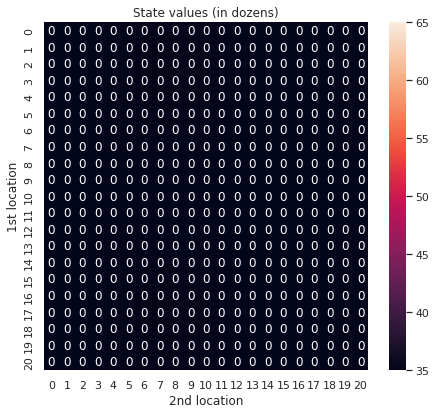

Policy evaluation: 5


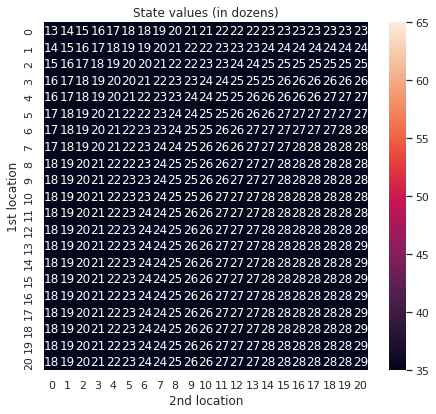

Policy evaluation: 10


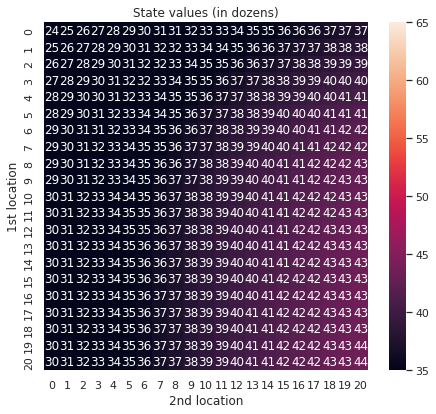

Policy evaluation: 15


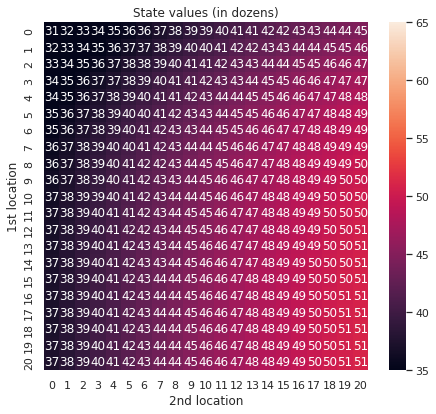

Policy evaluation: 20


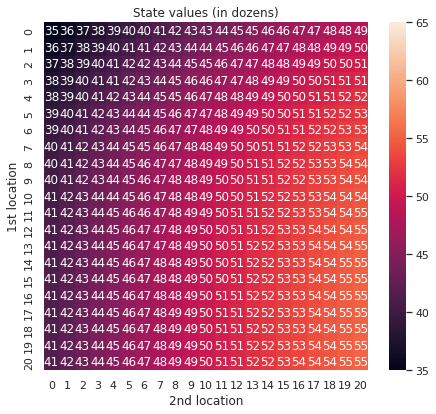

Policy evaluation: 25


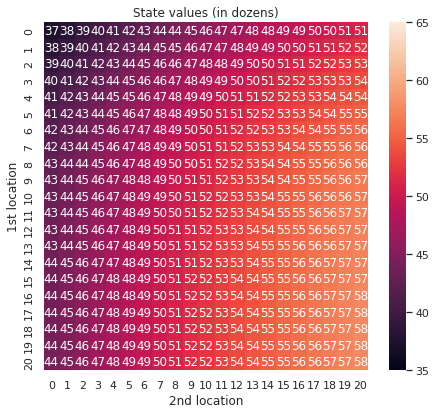

Policy evaluation: 30


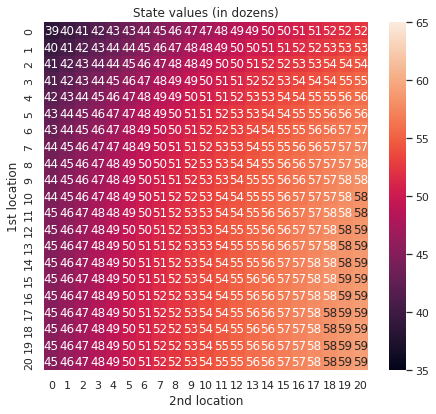

Policy evaluation: 35


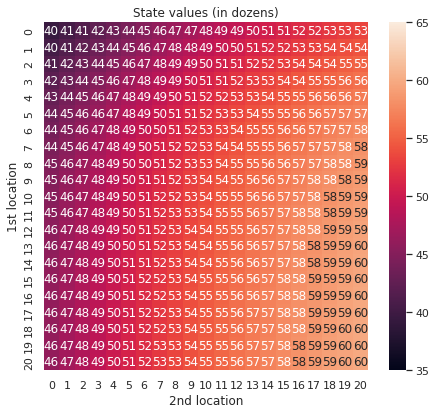

Policy evaluation finished in 38 steps


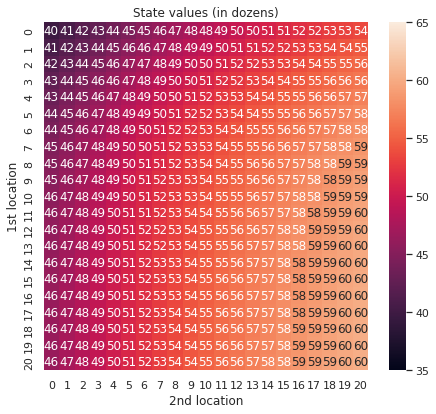

In [5]:
def q_value(n1, n2, action, gamma, V):
    q = 0.
    for n1_, n2_ in mdp.states_iter():
        # EXERCISE: Calculate the `action` quality in the state `(n1, n2)`
        # NOTE: Q(s, a) = \sum_{s'}P(s'|s, a)(r + \gamma * V(s'))

        # ANSWER
        p, r = T[n1, n2, action, n1_, n2_]
        q += p * (r + gamma * V[n1_, n2_])
        # END ANSWER
    
    return q

def policy_evaluation(gamma, theta, pi, V, visualize_each=0):
    i = 0
    while True:
        if visualize_each > 0 and i % visualize_each == 0:
            print("Policy evaluation: {}".format(i))
            visualize(V=V)
            plt.pause(0.05)
        
        V_old = np.copy(V)
        for n1, n2 in mdp.states_iter():
            # EXERCISE: Calculate the value backup
            # NOTE: Your policy is deterministic
            # HINT: Make use of the `q_value` function

            # ANSWER
            V[n1, n2] = q_value(n1, n2, pi[n1, n2], gamma, V_old)
            # END ANSWER

        # Early stopping
        max_diff = np.max(np.abs(V_old - V))
        if max_diff < theta:
            print("Policy evaluation finished in {} steps".format(i + 1))
            break
        i += 1

# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

policy_evaluation(gamma=0.9, theta=1., pi=pi, V=V, visualize_each=5)
visualize(V=V)

### Policy Improvement

It utilizes the one step lookahead to improve the policy based on its value function. At each state, it takes action that leads to the highest expected return.

$$
\forall_{s} \;\; \pi(s) \leftarrow \underset{a}{\text{argmax}} \sum_{s'}P(s'|s, a)\left(r + \gamma \cdot V(s')\right)
$$

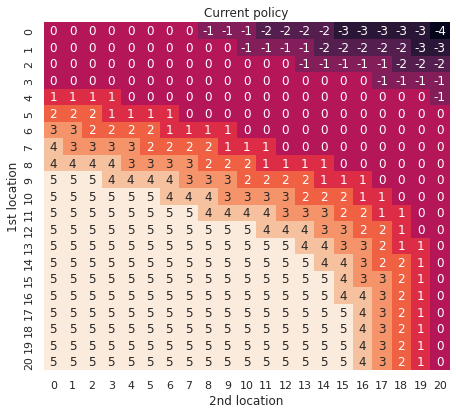

In [6]:
def policy_improvement(gamma, pi, V):
    pi_old = np.copy(pi)
    for n1, n2 in mdp.states_iter():
        # Get legal actions
        actions = list(mdp.actions_iter(n1, n2))

        # EXERCISE: Improve the policy
        # HINT: Make use of the `q_value` function

        # ANSWER
        # Get state-action value for each legal action
        q_values = list(map(lambda action: q_value(n1, n2, action, gamma, V), actions))
        
        # Improve the policy
        pi[n1, n2] = actions[np.argmax(q_values)]
        # END ANSWER
            
    return not np.all(pi == pi_old) # return if pi changed

policy_improvement(gamma=0.9, pi=pi, V=V)
visualize(pi=pi)

### Exercise

Answer the questions

1. Why the value is non-zero even when there are no cars at the 1st and 2nd location?

$V(s_i) = sum_{k=i, ...}(p(s_k) R(s_k))$

  > Answer: Value function is iterating over the other states -- it means that it takes into account future states, that will have for sure positive values.

1. Why the policy moves cars from the 1st location to the 2nd location, even if there isn't that many cars at the first location?

  > Answer: lambdas used in the problem for locations are different, so policy looks into future (into more global point of view, where having more cars in the second location is more affordable and makes loosing the game less probable).

### Combining the two

<ipython-input-7-e8150461d3db>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pi = np.zeros(STATE_SPACE, dtype=np.int)
<ipython-input-7-e8150461d3db>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  V = np.zeros(STATE_SP

Policy iteration step: 0


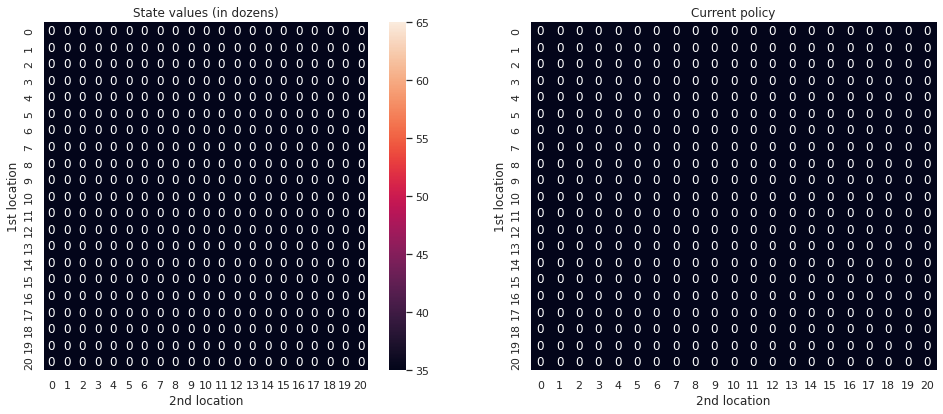

Policy evaluation finished in 60 steps
Policy iteration step: 1


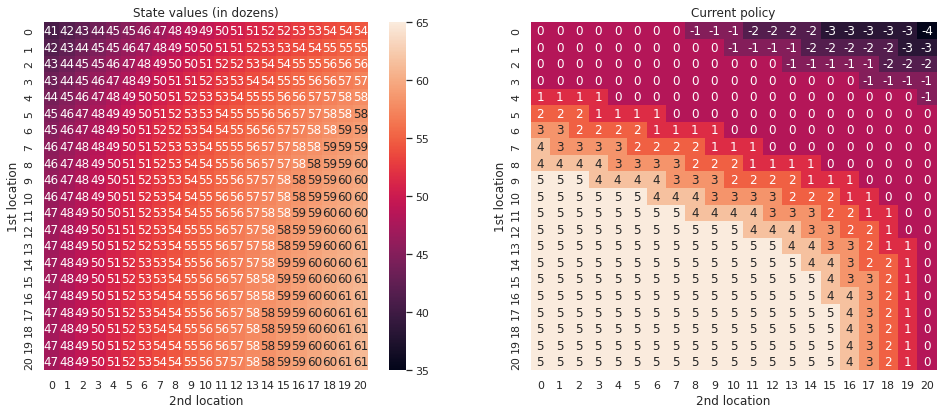

Policy evaluation finished in 26 steps
Policy iteration step: 2


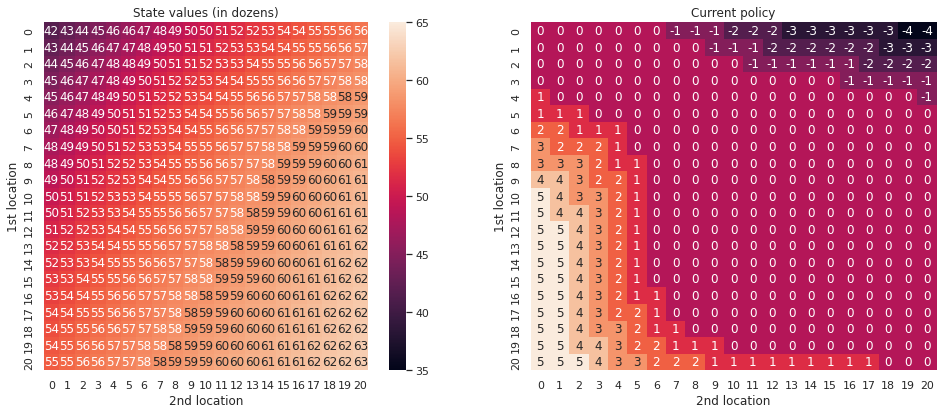

Policy evaluation finished in 19 steps
Policy iteration step: 3


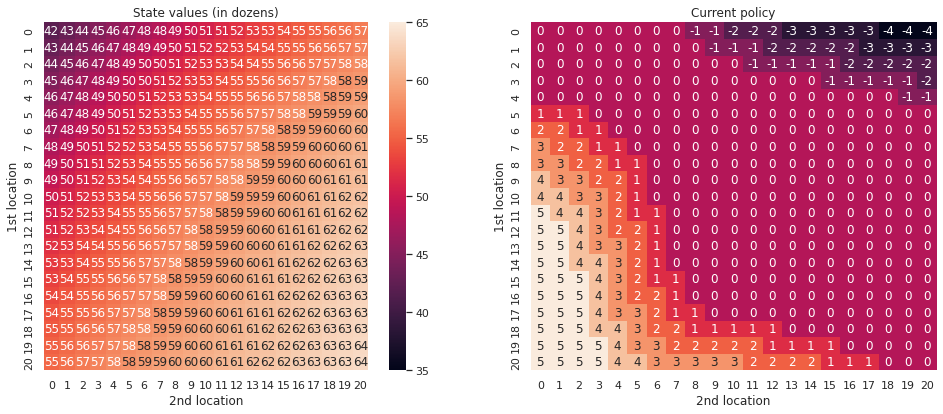

Policy evaluation finished in 5 steps
Policy iteration step: 4


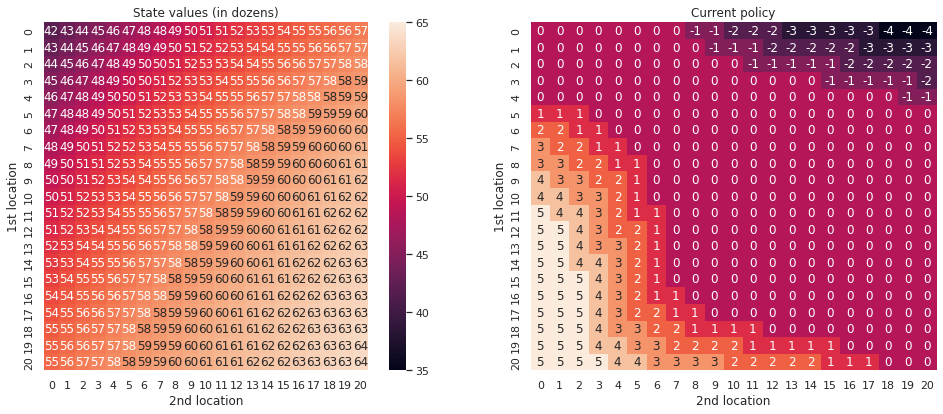

Policy evaluation finished in 2 steps
Policy iteration step: 5


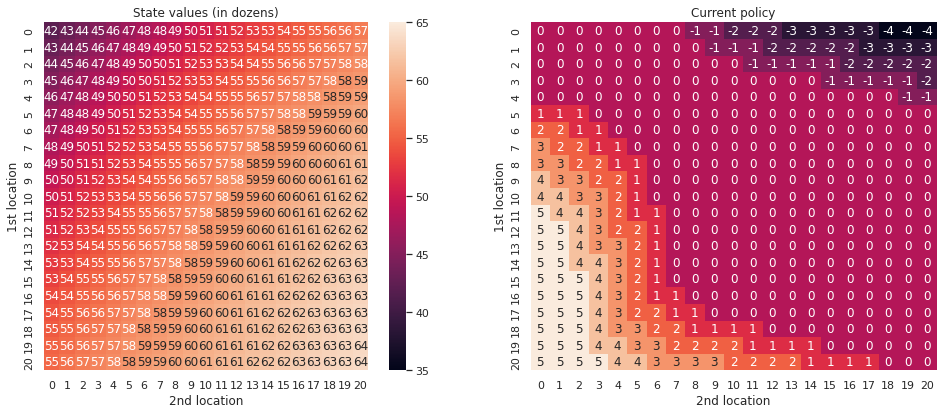

Policy evaluation finished in 1 steps
Policy iteration finished in 6 iterations!


In [7]:
# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

def policy_iteration(pi, V, gamma=0.9, theta=0.1):
    i = 0
    while True:
        print("Policy iteration step: {}".format(i))
        visualize(pi=pi, V=V)
        plt.pause(0.05)
        
        # EXERCISE: Combine policy evaluation and improvement

        # ANSWER
        policy_evaluation(gamma, theta, pi, V)
        changed = policy_improvement(gamma, pi, V)
        # END ANSWER
        
        if not changed:
            print("Policy iteration finished in {} iterations!".format(i + 1))
            break
        i += 1

policy_iteration(pi, V)

# 2. Value Iteration

Value Iteration combines the two steps, evaluation and improvement, into one update. It repeats until the values doesn't change anymore:

$$
\forall_{s} \;\; V(s) \leftarrow \max_a \sum_{s'}P(s'|s, a)\left(R(s, a, s') + \gamma \cdot V(s')\right)
$$

Value Iteration results is the optimal value function. Taking one step of policy improvement on it will immediatelly yield the optimal policy.

In [ ]:
def value_iteration(gamma, theta, V, visualize_each=0):
    i = 0
    while True:
        if visualize_each > 0 and i % visualize_each == 0:
            print("Value iteration: {}".format(i))
            visualize(V=V)
            plt.pause(0.05)
        
        V_old = np.copy(V)
        for n1, n2 in mdp.states_iter():
            # Get legal actions
            actions = list(mdp.actions_iter(n1, n2))
            
            # EXERCISE: Compute the value iteration update

            # ANSWER
            # Get state-action value for each legal action
            q_values = list(map(lambda action: q_value(n1, n2, action, gamma, V), actions))

            # Update the value function
            V[n1, n2] = np.max(q_values)
            # END ANSWER

        # Early stopping
        max_diff = np.max(np.abs(V_old - V))
        if max_diff < theta:
            print("Value iteration finished in {} steps".format(i + 1))
            break
        i += 1

# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

value_iteration(gamma=0.9, theta=0.1, V=V, visualize_each=5)
policy_improvement(gamma=0.9, pi=pi, V=V)
visualize(pi=pi, V=V)

### Exercise

Answer the questions

1. Which method, Policy Iteration or Value Iteration, converges faster and why?

  > Answer: Policy Iteration, because one policy represents more values. Also, it looks like Value Iteration is achieving good policy after 15 iteration, but converging value takes another 20 steps (even though during these steps policy changes just slightly). 

2. Can you make the problem unsolvable? How?

  > Answer: Increase the number of cars up to infinity or don't give a distribution of cars.